# [OGprimer chapter 2](https://github.com/OpenRG/OGprimer/blob/master/Chapters/OGtext_ch02.pdf) exercises

## 2.6 Calibration

Use the following parameterization of the model for the problems below. Because agents live
for only three periods, assume that each period of life is 20 years. If the annual discount
factor is estimated to be 0.96, then the 20-year discount factor is β = 0.9620 = 0.442.
Let the annual depreciation rate of capital be 0.05. Then the 20-year depreciation rate is
δ = 1 − (1 − 0.05)20 = 0.6415. Let the coefficient of relative risk aversion be σ = 3, let
the productivity scale parameter of firms be A = 1, and let the capital share of income be
α = 0.35.

In [1]:
run ch2_funs.py

In [2]:
# "Because agents live for only three periods, assume that each period of life
#  is 20 years."
PERIOD_YEARS = 20
# If the annual discount factor is estimated to be 0.96...
ANNUAL_DISCOUNT = 0.96
# ...then the 20-year discount factor is 0.96^20 = 0.442.
BETA = 0.442
# Let the annual depreciation rate of capital be 0.05.
ANNUAL_DEPR = 0.05
# Then the 20-year depreciation rate is 1 - (1 - 0.05)^20 = 0.6415.
DELTA = 0.6415
# Let the coefficient of relative risk aversion be 3,
SIGMA = 3
# let the productivityscale parameter of firms be A = 1,
A = 1
# and let the capital share of income be 0.35.
ALPHA = 0.35
# Assuming the same labor vector as section 2.1.
NVEC = [1, 1, 0.2]
L = sum(NVEC)

## Exercise 2.1
Using the calibration from Section 2.6, write a Python function named `feasible()` that has the following form,
```
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
```
where the inputs are a tuple `f_params = (nvec, A, alpha, delta)`, and a guess for the steady-state savings vector `bvec_guess = np.array([scalar, scalar])`.
The outputs should be Boolean (`True` or `False`, `1` or `0`)
vectors of lengths 2, 3, and 1, respectively.
`K_cnstr` should be a singleton Boolean that equals `True` if $K \leq 0$ for the given `f_params` and `bvec_guess`.

The object `c_cnstr` should be a length-3 Boolean vector in which the $s$th element equals `True` if $c_s \leq 0$
given `f_params` and `bvec_guess`.
And `b_cnstr` is a length-2 Boolean vector that denotes which element of `bvec_guess` is likely responsible for any of the consumption nonnegativity constraint violations identified in `c_cnstr`.
If the first element of `c_cnstr` is `True`, then the first element of `b_cnstr` is `True`.
If the second element of `c_cnstr` is `True`, then both elements of `b_cnstr` are `True`.
And if the last element of `c_cnstr` is `True`, then the last element of `b_cnstr` is `True`.

*Comment: Shrinking 3-element `c_cnstr` down to 2-element `b_cnstr` was confusing. Is this extra parsimony necessary?*

*Question: Should it be $c_s \leq 0$ or $c_s < 0$?*

## 2.1a

Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of `bvec_guess = np.array([1.0, 1.2])`?

In [3]:
F_PARAMS = (NVEC, A, ALPHA, DELTA)

In [4]:
feasible(F_PARAMS, np.array([1.0, 1.2]))

([True, False], [True, False, False], False)

In [5]:
infeasible(F_PARAMS, np.array([1.0, 1.2]))

True

### 2.1b

In [6]:
feasible(F_PARAMS, np.array([0.06, -0.001]))

([False, False], [False, False, False], False)

In [7]:
infeasible(F_PARAMS, np.array([0.06, -0.001]))

False

### 2.1c

In [8]:
feasible(F_PARAMS, np.array([0.1, 0.1]))

([False, False], [False, False, False], False)

In [9]:
infeasible(F_PARAMS, np.array([0.1, 0.1]))

False

## 2.2

Use the calibration function from Section 2.6 and the steady-state equilibrium Definition 2.1.
Write a function named `get_SS()` that has the following form,
```
ss_output = get_SS(params, bvec_guess, SS_graphs)
```
where the inputs are a tuple of the parameters for the model
`params = ((beta, sigma, nvec, L, A, alpha, delta, SS_tol))`,
and initial guess of the steady-state savings `bvec_guess`,
and a Boolean `SS_graphs` that generates a figure of the
steady-state distribution of consumption and savings
if it is set to `True`.
The output object `ss_output` is a Python dictionary
with the steady-state solution values for the following
endogenous objects.
```
ss_output - {
    'b_ss': b_ss,
    'c_ss': c_ss,
    'w_ss': w_ss,
    'r_ss': r_ss,
    'K_ss': K_ss,
    'Y_ss': Y_ss,
    'C_ss': C_ss,
    'EulErr_ss': EulErr_ss,
    'RCerr_ss': RCerr_ss,
    'ss_time': ss_time
}
```
Let `ss_time` be the number of seconds it takes to run your steady-stateprogram.
You can time your program by importing the `time` library.
```
import time
...
start_time = time.clock()  # Place at beginning of get_SS()
...
ss_time = time.clock() - start_time  # Place at end of get_SS()
```
And let the object EulErr_ss be a length-2 vector of the
two Euler errors from the resulting steady-state
solution given in difference form
$\beta (1 + \bar{r})u'(\bar{c}_{s+1}) -u'(\bar{c}_s)$.
The object `RCerr_ss` is a resource constraint error which should be close to zero.
It is given by $\bar{Y} - \bar{C} - \delta \bar{K}$.

### 2.2a

Solve numerically for the steady-state equilibrium values of ${\bar{c}_s}_{s=1}^3, {\bar{b}_s}_{s=2}^3, \bar{w}, \bar{r}, \bar{K}, \bar{Y}, \bar{C},$
the two Euler errors and the resource constraint error.
List those values.
Time your function.
How long did it take to compute the steady-state?

In [10]:
PARAMS = BETA, SIGMA, NVEC, L, A, ALPHA, DELTA
SS_TOL = 1e-10

In [11]:
ss = get_SS(PARAMS + (SS_TOL,), [0.1, 0.1], False)
ss

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': array([-1.39266376e-12,  2.62900812e-12]),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.0007980000000000764}

### 2.2b

Generate a figure that shows the steady-state distribution of consumption and savings by age ${\bar{c}_s}_{s=1}^3$ and ${\bar{b}_s}_{s=2}^3$.

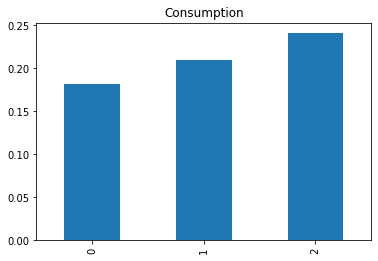

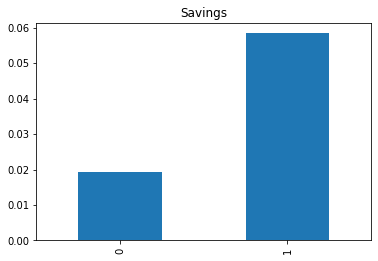

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': array([-1.39266376e-12,  2.62900812e-12]),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.0008429999999999271}

In [12]:
get_SS(PARAMS + (SS_TOL,), [0.1, 0.1], True)

### 2.2c

What happens to each of these steady-state values if all households become more patient
$\beta \uparrow$
(an example would be $\beta = 0.55$)?
That is, in what direction does $\beta \uparrow$
move each steady-state value? What is the intuition?

*Capital, consumption, and wages rise; interest rate falls.*

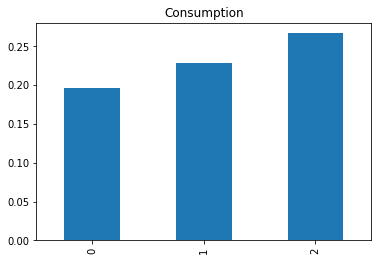

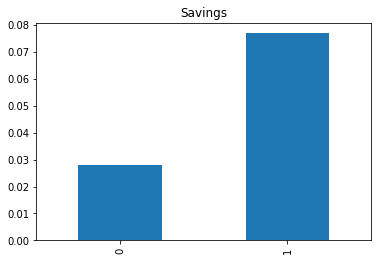

{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': (0.19597527701928266, 0.22861594138399466, 0.2666930719518642),
 'w_ss': 0.22415219593446262,
 'r_ss': 1.8863765057190747,
 'K_ss': 0.10504237022597478,
 'Y_ss': 0.7586689708551043,
 'C_ss': 0.6912842903551415,
 'EulErr_ss': array([ 5.68434189e-14, -2.84217094e-14]),
 'RCerr_ss': 1.3877787807814457e-17,
 'ss_time': 0.000596000000000263}

In [13]:
BETA = 0.55
PARAMS = BETA, SIGMA, NVEC, L, A, ALPHA, DELTA
get_SS(PARAMS + (SS_TOL,), [0.1, 0.1], True)

## 2.3

Use time path iteration (TPI) to solve for the non-steady state equilibrium transition path of the economy from $(b_{2,1},b_{3,1})=(0.8 \bar{b}_2, 1.1\bar{b}_3)$ to the steady-state $(\bar{b}_2, \bar{b}_3)$.
You'll have to choose a guess for $T$ and a time path updating parameter $\xi \in (0,1)$,
but I can assure you that $T<50$.
Use an $L^2$ norm for your distance measure
(sum of squared percent deviations),
and use a convergence parameter of $\epsilon=10^{-9}$.
Use a linear initial guess for the time path of the
aggregate capital stock from the initial state
$K_1^1$ to the steady state $K_T^1$ at time $T$.

In [14]:
T = 50
XI = 0.3
M = 3

In [15]:
tpi_sol = tpi(b0_ratios=np.array([0.8, 1.1]), bvec_guess=[0.1, 0.1],
              beta=BETA, sigma=SIGMA, nvec=NVEC, L=L, A=A, alpha=ALPHA,
              delta=DELTA, T=T, m=M, xi=XI, tol=1e-9)

### 2.3a

Report the maximum of the absolute values of all the Euler errors across the
entire time path.
Also report the maximum of the absolute value of all the aggregate resource
constraint errors $Y_t - C_t - K_{t+1} + (1-\delta)K_t$ across the entire time path.

In [16]:
# Euler errors.
Kpath = tpi_sol.sum(axis=0)
wpath = get_wpath(Kpath, ALPHA, A, L, M)
rpath = get_rpath(Kpath, ALPHA, A, L, DELTA, M)

eulerrs = np.zeros((T, 2))
for t in range(T):
    eulerrs[t] = tpi_pair_opt_fun([tpi_sol[0][t], tpi_sol[1][t]], wpath,
                                  rpath, BETA, SIGMA, NVEC, t)
abs(eulerrs).max()

9.151909455514172

In [17]:
# Resource constraint errors.
Y = A * (Kpath ** ALPHA) * (L ** (1 - ALPHA))
C = np.array([c(tpi_sol[0][t], tpi_sol[1][t], wpath[t], rpath[t], NVEC)
              for t in range(T)]).sum(axis=1)
rc_errs = Y[:T] - C - Kpath[1:T+1] + (1 - DELTA) * Kpath[:T]
abs(rc_errs).max()

0.1982881664618553

### 2.3b

Plot the equilibrium time paths of the
aggregate capital stock $\{K_t\}_{t=1}^{T+5}$,
wage $\{w_t\}_{t=1}^{T+5}$,
and interest rate $\{r_t\}_{t=1}^{T+5}$.

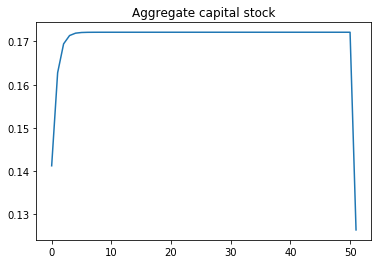

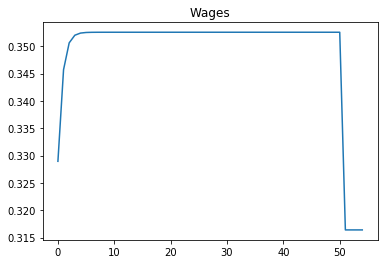

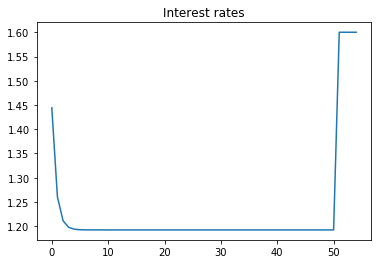

In [18]:
pd.Series(Kpath).plot()
plt.title('Aggregate capital stock')
plt.show()
pd.Series(wpath).plot()
plt.title('Wages')
plt.show()
pd.Series(rpath).plot()
plt.title('Interest rates')
plt.show()

### 2.3c

How many periods did it take for the economy to get within 0.00001 of the
steady-state aggregate capital stock $\bar{K}$?
What is the period after which the aggregate capital stock never is again
farther than 0.00001 away from the steady-state?

In [19]:
# Something's wrong.
abs(Kpath - ss['K_ss'])

array([0.06349207, 0.08503815, 0.09172089, 0.09365243, 0.09419957,
       0.09435365, 0.09439693, 0.09440907, 0.09441245, 0.09441339,
       0.09441364, 0.09441371, 0.09441373, 0.09441373, 0.09441373,
       0.09441373, 0.09441373, 0.09441373, 0.09441373, 0.09441373,
       0.09441373, 0.09441373, 0.09441373, 0.09441373, 0.09441373,
       0.09441373, 0.09441373, 0.09441373, 0.09441373, 0.09441373,
       0.09441373, 0.09441373, 0.09441372, 0.09441372, 0.09441372,
       0.09441372, 0.09441372, 0.09441372, 0.09441372, 0.09441372,
       0.09441372, 0.09441372, 0.09441372, 0.09441372, 0.09441372,
       0.09441372, 0.09441372, 0.09441372, 0.09441372, 0.09441372,
       0.09441372, 0.04864388])